In [20]:
区域大小 = 100
总人口数 = 100000
医院床位 = 2000
方舱床位 = 10000

潜伏期分布 = (6, 2)
发病期分布 = (10, 3)
传染起始日 = -1
传播概率 = 0.5
免疫概率 = 0.1
重症概率 = 0.05
病亡概率 = 0.1
救治概率 = 0.95

入院意愿 = 0.1
进方舱概率 = 0.99

出行意愿 = 0.8
戴口罩意愿=float(input("请输入防疫参数，在0到1之间"))
常住区域概率 = 0.8
周边出行概率 = 0.95
接触比例 = 0.5
警戒人数 = 1000
解除时间 = 999

请输入防疫参数，在0到1之间0.8


In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt

000123456789101112131415161718192021222324252627282930313233343536373839404142!43!44!45!46!47!48!49!50!51!52!53!54!55!56!57!58!59!60!616263646566676869707172737475767778798081828384858687888990919293949596979899

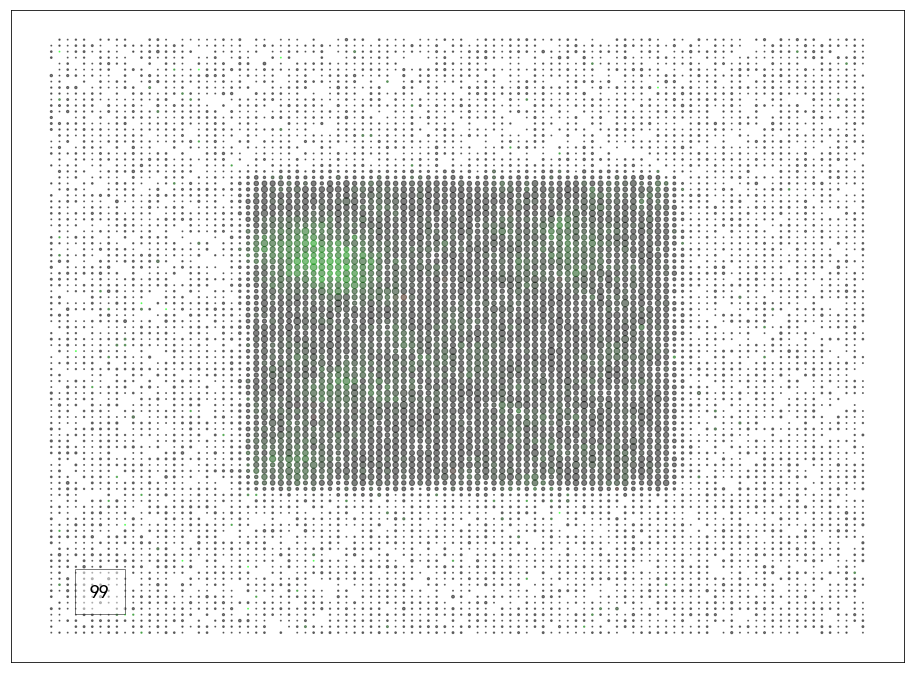

In [23]:
总人员列表 = []
住院人员列表 = [] 
方舱人员列表 = []
病亡人员列表= []

区域分布列表 = [[[] for i in range(区域大小)] for j in range(区域大小)]

class 人():
    def __init__(self, i):
        self.uid = i
        self.x, self.y = self.随机位置()
        self.常住区域 = set()
        self.常住区域数量 = random.randint(3, 6)
        区域分布列表[self.x][self.y].append(self)
        self.常住区域.add((self.x, self.y))
        self.已感染 = False
        self.传染性 = False
        self.免疫 = random.random() < 免疫概率
        self.已入院 = False
        self.已进方舱 = False
        self.身体状况 = '健康'
        self.感染后天数 = 0
        self.潜伏期 = 0
        self.发病期 = 0
        self.传染期 = 0

    def 随机位置(self):
        # 80%人分布在25%区域
        L = int(0.25 * 区域大小)
        if random.random() < 0.8:
            px = random.randint(L, 区域大小-L)
            py = random.randint(L, 区域大小-L)
        else:
            px = random.randint(0, 区域大小-1)
            py = random.randint(0, 区域大小-1)
        return px, py
    
    def 更新位置(self, in_his=False):
        区域分布列表[self.x][self.y].remove(self)
        if in_his:
            # 在常住区域移动
            pos = random.choice(list(self.常住区域))
        else:
            # 去新区域
            if random.random() < 周边出行概率:
                # 在周边九宫格移动
                off_x = random.randint(-1, 1)
                off_y = random.randint(-1, 1)
                pos = (max(min(self.x + off_x, 区域大小-1), 0), max(min(self.y + off_y, 区域大小-1), 0))
            else:
                pos = self.随机位置()
        self.x, self.y = pos
        区域分布列表[self.x][self.y].append(self)
        if len(self.常住区域) < self.常住区域数量:
            self.常住区域.add((self.x, self.y))
        
    def 出行(self):
        if not self.已入院 and not self.已进方舱 and random.random() < 出行意愿:
            if len(self.常住区域) < self.常住区域数量:
                self.更新位置()
            else:
                if random.random() < 常住区域概率:
                    # 在常住区域移动
                    self.更新位置(True)
                else:
                    # 去新区域
                    self.更新位置()

    def 被传染(self):
        self.已感染 = True
        self.身体状况 = '潜伏'
        self.潜伏期 = random.gauss(潜伏期分布[0], 潜伏期分布[1])
        self.发病期 = self.潜伏期 + random.gauss(发病期分布[0], 发病期分布[1])
        self.传染期 = self.潜伏期 + 传染起始日
        
    def 传染(self):
        others = 区域分布列表[self.x][self.y]
        count = len(others)
        touch = random.sample(others, int(count * 接触比例) + 1)
        for h in touch:
            infect_rate = 传播概率
            if random.random() < 戴口罩意愿:
                # 概率降低到5%
                infect_rate *= 0.05
            if h.身体状况 == '健康' and not h.免疫 and random.random() < infect_rate:
                h.被传染()
        
    def 病情发展(self):
        if not self.已感染:
            return
        self.感染后天数 += 1
        if not self.传染性 and self.感染后天数 >= self.传染期:
            self.传染性 = True
        if self.身体状况 == '潜伏' and self.感染后天数 >= self.潜伏期:
            self.身体状况 = '发病'
        if self.身体状况 == '发病':
            if 方舱床位 > 0:
                # 分级收治，轻症进方舱
                if not self.已入院 and not self.已进方舱 and random.random() < 进方舱概率 and len(方舱人员列表) < 方舱床位:
                    # 进方舱
                    self.已进方舱 = True
                    方舱人员列表.append(self)
                    区域分布列表[self.x][self.y].remove(self)
            else:
                if not self.已入院 and len(住院人员列表) < 医院床位 and random.random() < 入院意愿:
                    self.已入院 = True
                    住院人员列表.append(self)
                    if self.已进方舱:
                        self.已进方舱 = False
                        方舱人员列表.remove(self)
                    else:
                        区域分布列表[self.x][self.y].remove(self)
            if self.感染后天数 >= self.发病期:
                self.康复()
            elif random.random() < 重症概率:
                self.身体状况 = '重症'  # 转重症
        if self.身体状况 == '重症':
            dead_rate = 病亡概率
            if self.已入院:
                dead_rate *= (1 - 救治概率)
            elif len(住院人员列表) < 医院床位:
                dead_rate *= (1 - 救治概率)
                self.已入院 = True
                住院人员列表.append(self)
                if self.已进方舱:
                    self.已进方舱 = False
                    方舱人员列表.remove(self)
                else:
                    区域分布列表[self.x][self.y].remove(self)
            if random.random() < dead_rate:
                self.病亡()
            elif self.感染后天数 >= self.发病期:
                self.康复()

                
    def 病亡(self):
        self.身体状况 = '病亡'
        self.已感染 = False
        self.传染性 = False
        if self.已入院:
            self.已入院 = False
            住院人员列表.remove(self)
        if self.已进方舱:
            self.已进方舱 = False
            方舱人员列表.remove(self)
        总人员列表.remove(self)      # 从列表中移除
        病亡人员列表.append(self)
        
    def 康复(self):
        self.身体状况 = '康复'
        self.已感染 = False
        self.传染性 = False
        if self.已入院:
            self.已入院 = False
            住院人员列表.remove(self)
            区域分布列表[self.x][self.y].append(self)
        if self.已进方舱:
            self.已进方舱 = False
            方舱人员列表.remove(self)
            区域分布列表[self.x][self.y].append(self)

x = np.zeros(区域大小 * 区域大小)
y = np.zeros(区域大小 * 区域大小)
for i in range(区域大小):
    for j in range(区域大小):
        x[i*区域大小+j] = i
        y[i*区域大小+j] = j

for i in range(总人口数):
    总人员列表.append(人(i))
h = 总人员列表[0]  # 零号病人
h.已感染 = True

import matplotlib.animation as animation
from IPython.display import HTML

健康曲线 = []
感染曲线 = []
康复曲线 = []
病亡曲线 = []
医院曲线 = []
方舱曲线 = []

def update(t):
    print(t, end='')
                
    传染人员列表 = []
    for h in 总人员列表:
        h.出行()
        h.病情发展()
        if h.传染性 and not h.已入院 and not h.已进方舱:
            传染人员列表.append(h)
            
    for h in 传染人员列表:
        h.传染()

    jk = gr = kf = bw = fb = 0
    for h in 总人员列表:
        if h.身体状况 == '健康':
            jk += 1
        elif h.身体状况 == '潜伏' or h.身体状况 == '发病' or h.身体状况 == '重症':
            gr += 1
            if h.身体状况 != '潜伏':
                fb += 1
        elif h.身体状况 == '康复':
            kf += 1
        elif h.身体状况 == '病亡':
            bw += 1
    健康曲线.append(jk)
    感染曲线.append(gr)
    康复曲线.append(kf)
    病亡曲线.append(len(病亡人员列表))
    医院曲线.append(len(住院人员列表))
    方舱曲线.append(len(方舱人员列表))

    if fb > 警戒人数:
        print('!', end='')
        global 戴口罩意愿
        global 出行意愿
        global 接触比例
        global 入院意愿

        出行意愿 = 0.2
        接触比例 = 0.2
        入院意愿 = 1
    if t > 解除时间:
        戴口罩意愿 = 0.1
        出行意愿 = 0.8
        接触比例 = 0.4
    
    
    for i in range(区域大小):
        for j in range(区域大小):
            count = len(区域分布列表[i][j])
            sizes[i*区域大小+j] = count
            感染人数 = 0
            康复人数 = 0
            for h in 区域分布列表[i][j]:
                if h.已感染:
                    感染人数 += 1
                elif h.身体状况 == '康复':
                    康复人数 += 1
            if count > 0:
                colors[i*区域大小+j] = '#%s%s00' % ('{:02x}'.format(int(感染人数 / count * 255)),
                                                   '{:02x}'.format(int(康复人数 / count * 255)))
            else:
                colors[i*区域大小+j] = '#000000'                    

    # 标记测试人
#     colors[:] = '#999999'
#     colors[总人员列表[0].x*区域大小 + 总人员列表[0].y] = '#ff0000'
#     colors[总人员列表[1].x*区域大小 + 总人员列表[1].y] = '#00ff00'
#     colors[总人员列表[2].x*区域大小 + 总人员列表[2].y] = '#0000ff'
#     sizes[总人员列表[0].x*区域大小 + 总人员列表[0].y] = 50
#     sizes[总人员列表[1].x*区域大小 + 总人员列表[1].y] = 50
#     sizes[总人员列表[2].x*区域大小 + 总人员列表[2].y] = 50

    sc.set_sizes(sizes)
    sc.set_color(colors)
    title.set_text(t)

    return sc,

sizes = np.zeros(区域大小*区域大小)
for i in range(区域大小):
    for j in range(区域大小):
        sizes[i*区域大小+j] = len(区域分布列表[i][j])
colors = np.zeros(区域大小*区域大小, dtype='U7')
colors[:] = '#000000'
fig, ax = plt.subplots(figsize=(16, 12))
plt.xticks([])
plt.yticks([])

title = ax.text(0.1, 0.1, '', bbox={'facecolor':'w', 'alpha':0.5, 'pad':15},
                transform=ax.transAxes, ha="center", fontsize=20)
sc = ax.scatter(x, y, s=sizes, c=colors, alpha=0.5)
ani = animation.FuncAnimation(fig, update, frames=100, interval=100, blit=True, repeat=False)
HTML(ani.to_html5_video())

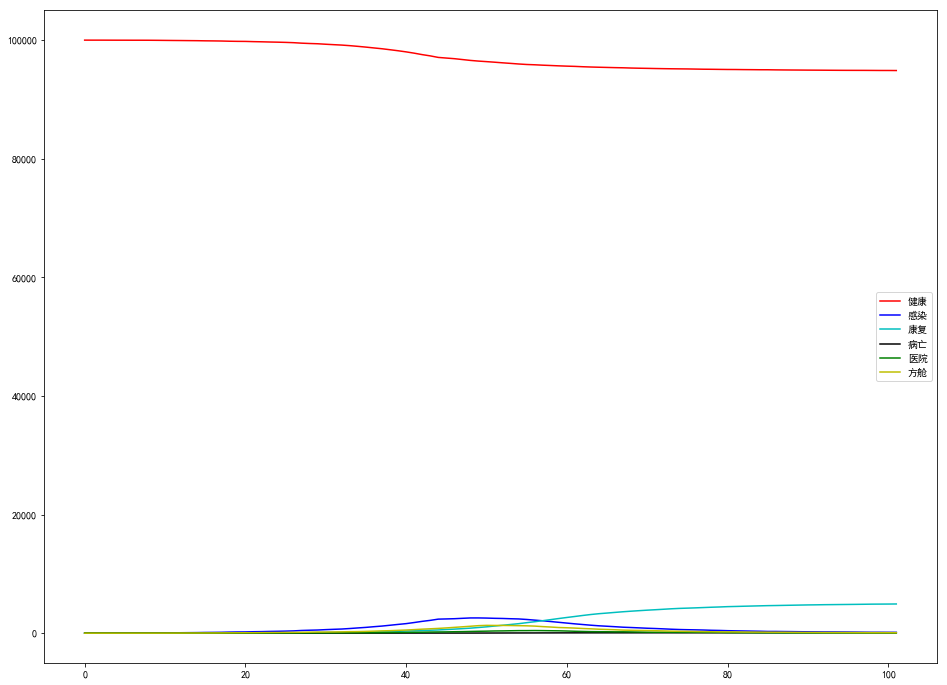

In [24]:
from pylab import mpl
plt.rcParams['font.sans-serif']=['SimHei']

plt.figure(figsize=(16, 12))
plt.plot(健康曲线, 'r')
plt.plot(感染曲线, 'b')
plt.plot(康复曲线, 'c')
plt.plot(病亡曲线, 'k')
plt.plot(医院曲线, 'g')
plt.plot(方舱曲线, 'y')
plt.legend(['健康', '感染', '康复', '病亡', '医院', '方舱'])
# plt.legend(['健康', '感染', '康复', '病亡', '医院'], prop=font)
plt.show()




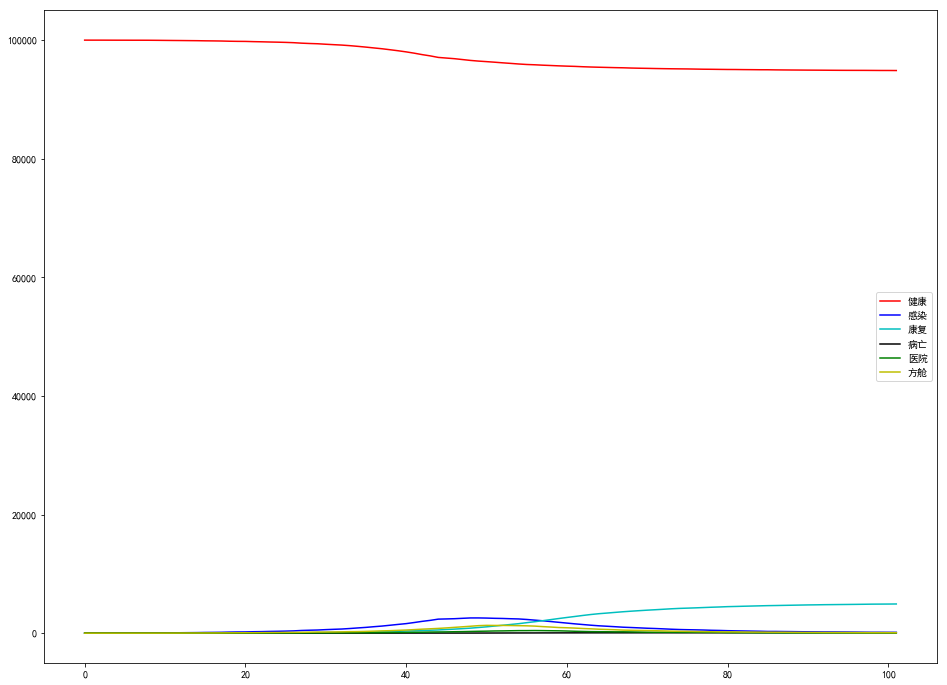

In [25]:
from pylab import mpl
plt.rcParams['font.sans-serif']=['SimHei']

plt.figure(figsize=(16, 12))
plt.plot(健康曲线, 'r')
plt.plot(感染曲线, 'b')
plt.plot(康复曲线, 'c')
plt.plot(病亡曲线, 'k')
plt.plot(医院曲线, 'g')
plt.plot(方舱曲线, 'y')
plt.legend(['健康', '感染', '康复', '病亡', '医院', '方舱'])
# plt.legend(['健康', '感染', '康复', '病亡', '医院'], prop=font)
plt.show()



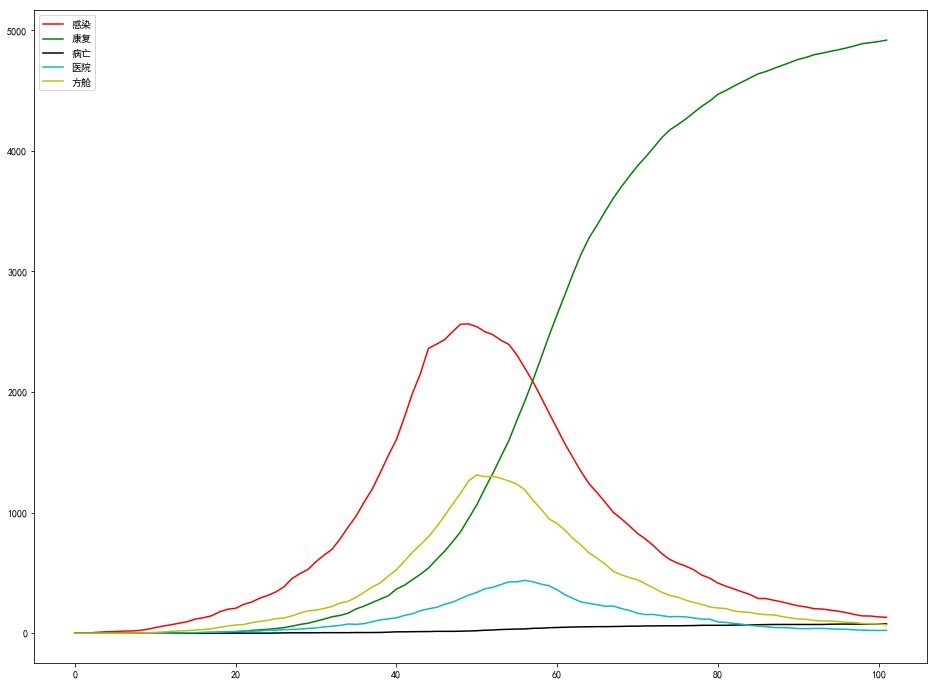

In [26]:
fig2, ax2 = plt.subplots(figsize=(16, 12))

# line1, = ax2.plot(健康曲线, 'b')
line2, = ax2.plot(感染曲线, 'r')
line3, = ax2.plot(康复曲线, 'g')
line4, = ax2.plot(病亡曲线, 'k')
line5, = ax2.plot(医院曲线, 'c')
line6, = ax2.plot(方舱曲线, 'y')
plt.legend(['感染', '康复', '病亡', '医院', '方舱'])

In [27]:
print(康复曲线[-1], 病亡曲线[-1], '%.3f' % (病亡曲线[-1]/(康复曲线[-1] + 病亡曲线[-1])))


4919 77 0.015


In [28]:
感染曲线

[1,
 3,
 3,
 8,
 12,
 13,
 17,
 18,
 22,
 32,
 46,
 59,
 70,
 83,
 95,
 117,
 128,
 144,
 177,
 198,
 206,
 239,
 258,
 290,
 313,
 342,
 383,
 452,
 494,
 528,
 593,
 647,
 696,
 782,
 880,
 972,
 1088,
 1195,
 1332,
 1473,
 1605,
 1790,
 1989,
 2154,
 2363,
 2397,
 2434,
 2501,
 2563,
 2565,
 2542,
 2501,
 2476,
 2430,
 2395,
 2308,
 2197,
 2086,
 1958,
 1826,
 1698,
 1568,
 1453,
 1338,
 1238,
 1164,
 1085,
 1002,
 949,
 890,
 828,
 781,
 725,
 662,
 612,
 581,
 556,
 526,
 482,
 456,
 416,
 390,
 367,
 343,
 321,
 288,
 287,
 272,
 259,
 242,
 227,
 217,
 203,
 200,
 191,
 182,
 170,
 155,
 143,
 142,
 135,
 131]

In [35]:
xinzen=np.zeros(100)
xinzen[0]=1
时间表=np.zeros(3)
import numpy as np
import datetime
def yuce(time_2):
    a=0
    time_1 = "2020-01-20"

    d1 = datetime.datetime.strptime(time_1, '%Y-%m-%d')
    d2 = datetime.datetime.strptime(time_2, '%Y-%m-%d')
    delta = (d2- d1).days
    delta=int(delta)


    xinzen[0]=感染曲线[0]
    for i in range(len(感染曲线)-2):
        xinzen[i]=感染曲线[i+1]-感染曲线[i]
    for i in range(len(xinzen)):
        if xinzen[i]>=5:
            时间表[0]=i
            break
    for i in range(len(xinzen)):
        if xinzen[i]<0:
            时间表[1]=i-5
            break
    max1=max(感染曲线)
    index=np.argmax(感染曲线)
    for i in range(len(感染曲线)-index):
        if 感染曲线[index+i-1]<0.2*max1:
            时间表[2]=index+i+10
            break
    if delta<时间表[0]:
        print("注意警惕，目前疫情正处于散布阶段")
    elif delta<时间表[1]:
        print("请待在家，不要出门")
    elif delta<时间表[2]:
        print("还不能放松警惕，有可能再爆发")
    else:
        print("可以出去玩了，记得远离聚集哦")
    
    
    
    
        
        
    
    
   
    
    
    
    


    


In [36]:
len(感染曲线)

102

In [37]:
ffff=str(input("请输入查询日期"))
yuce(ffff)


请输入查询日期2020-04-3
还不能放松警惕，有可能再爆发


In [32]:
时间表

array([ 2., 44., 89.])

In [33]:
xinzen

array([   2.,    0.,    5.,    4.,    1.,    4.,    1.,    4.,   10.,
         14.,   13.,   11.,   13.,   12.,   22.,   11.,   16.,   33.,
         21.,    8.,   33.,   19.,   32.,   23.,   29.,   41.,   69.,
         42.,   34.,   65.,   54.,   49.,   86.,   98.,   92.,  116.,
        107.,  137.,  141.,  132.,  185.,  199.,  165.,  209.,   34.,
         37.,   67.,   62.,    2.,  -23.,  -41.,  -25.,  -46.,  -35.,
        -87., -111., -111., -128., -132., -128., -130., -115., -115.,
       -100.,  -74.,  -79.,  -83.,  -53.,  -59.,  -62.,  -47.,  -56.,
        -63.,  -50.,  -31.,  -25.,  -30.,  -44.,  -26.,  -40.,  -26.,
        -23.,  -24.,  -22.,  -33.,   -1.,  -15.,  -13.,  -17.,  -15.,
        -10.,  -14.,   -3.,   -9.,   -9.,  -12.,  -15.,  -12.,   -1.,
         -7.])

In [16]:
xinzen[0]=1

In [ ]:
max(感染曲线)

In [16]:
def go(t):
#     line1.set_data(range(t), 健康曲线[:t])
    line2.set_data(range(t), 感染曲线[:t])
    line3.set_data(range(t), 康复曲线[:t])
    line4.set_data(range(t), 病亡曲线[:t])
    line5.set_data(range(t), 医院曲线[:t])
    line6.set_data(range(t), 方舱曲线[:t])
    return line2, line3, line4, line5, line6

ani2 = animation.FuncAnimation(fig2, go, frames=100, interval=100, blit=True, repeat=False)
HTML(ani2.to_html5_video())